Made by: Andrei Kulchyk (155489) and Fiodar Piatrovich (155174)

[Github](https://github.com/aaakulchyk/put-evolutionary-computations)

# Description of a problem

We are given three columns of integers with a row for each node. The first two columns contain x and y coordinates of the node positions in a plane. The third column contains node costs. The goal is to select exactly 50% of the nodes (if the number of nodes is odd we round the number of nodes to be selected up) and form a Hamiltonian cycle (closed path) through this set of nodes such that the sum of the total length of the path plus the total cost of the selected nodes is minimized.

The distances between nodes are calculated as Euclidean distances rounded mathematically to
integer values. The distance matrix should be calculated just after reading an instance and then only
the distance matrix (no nodes coordinates) should be accessed by optimization methods to allow
instances defined only by distance matrices.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from pathlib import Path

import pandas as pd
from joblib import Parallel, delayed

from hamiltonian_cycle.algorithms.lab1 import init_random_solution
from hamiltonian_cycle.algorithms.lab7 import LargeNeighborhoodSearch
from hamiltonian_cycle.algorithms.lab2 import init_greedy_2regret_weighted_cycle
from hamiltonian_cycle.algorithms.lab3_4 import LocalSearch
from hamiltonian_cycle.costs import dm, function_cost
from hamiltonian_cycle.plots import plot_solution
import matplotlib.pyplot as plt
import random
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import numpy as np
import time


/Users/theodore/Repos/put-evolutionary-computations/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def read_dataset_csv(csv_path: Path) -> pd.DataFrame:
    return pd.read_csv(csv_path, sep=";", names=["x", "y", "cost"])


DATA_DIR = Path("../data").resolve()

ds_a = read_dataset_csv(DATA_DIR / "TSPA.csv")
ds_b = read_dataset_csv(DATA_DIR / "TSPB.csv")

dm_a = dm(ds_a)
dm_b = dm(ds_b)

# Hybrid Evolutionary Algorithm

## Psuedo code for HEA
```
Step 1: Generate intial solution
    - Generate random solutions of population_size
    - Apply EdgeSteepestLocalSearch to generated solutions
    - Repeat proceedure, if resulting population is not distinct.

WHILE time_budget not exceeded:

    Step 2: Select parents
        - Randomly select two different parents (parent1, parent2) uniformly from the population.

    Step 3: Apply recombination
        - IF random.random() < use_operator_1_prob:
            child_solution = recombination_operator_1(parent1, parent2, all_nodes)
        - ELSE:
            child_solution = recombination_operator_2(parent1, parent2, ds, dm)

    Step 4: Optional local search
        - IF with_local_search_after_recombination is True:
            child_solution = EdgeSteepestLocalSearch(ds, dm, child_solution)

    Step 5: Evaluate child solution
        - Calculate child_cost = function_cost(ds.loc[child_solution])

    Step 6: Update population
        - IF child_cost < max(population_costs) AND child_solution is unique in population:
            Replace the worst solution in the population with child_solution.

RETURN the best solution (minimum cost in population) and num_iterations.
```


## Psuedo code for Opearator 1
```
Step 1: Combine common edges
    - Randomly choose either parent1 or parent2 as the starting point.
    - Create child_solution by adding nodes from common_edges in the order they appear in the chosen parent.

Step 2: Fill remaining nodes
    - Identify remaining_nodes = all_nodes - nodes in child_solution.
    - Shuffle remaining_nodes randomly.
    - Add nodes from remaining_nodes to child_solution until its size matches parent1.

RETURN child_solution.
```

## Psuedo code for Opearator 2
```
Step 1: Combine common edges
    - Randomly choose either parent1 or parent2 as the starting point.
    - Create child_solution by adding nodes from common_edges in the order they appear in the chosen parent.

Step 2: Repair the child solution
    - Use init_greedy_2regret_weighted_cycle to repair child_solution:
        - Start with child_solution as the initial solution.
        - Apply the greedy weighted Heurisitc to ensure it forms a valid Hamiltonian cycle.

RETURN repaired child_solution.

```

In [4]:
def find_common_edges(parent1: list[int], parent2: list[int]):
    size = len(parent1)

    # Convert edges to unordered pairs
    parent1_edges = [
        tuple(sorted((parent1[i], parent1[(i + 1) % size]))) for i in range(size)
    ]
    parent2_edges = [
        tuple(sorted((parent2[i], parent2[(i + 1) % size]))) for i in range(size)
    ]
    common_edges = set(parent1_edges).intersection(parent2_edges)

    return common_edges


def combine_common_edges(
    parent1: list[int], parent2: list[int], common_edges: set
) -> list[int]:
    # Randomly select either parent1 or parent2 as the starting point
    starting_parent = random.choice([parent1, parent2])

    # Start forming the child solution
    child = []
    # Add nodes from common edges in the order they appear in `starting_parent`
    for node in starting_parent:
        if any(node in edge for edge in common_edges):
            child.append(node)
    return child


def recombination_operator_1(
    parent1: list[int], parent2: list[int], all_nodes: list[int]
) -> list[int]:
    common_edges = find_common_edges(parent1, parent2)

    child = combine_common_edges(parent1, parent2, common_edges)

    # Fill remaining nodes randomly
    remaining_nodes = [node for node in all_nodes if node not in child]
    random.shuffle(remaining_nodes)

    # Complete the solution to the required size
    child.extend(remaining_nodes[: len(parent1) - len(child)])
    return child


def recombination_operator_2(
    parent1: list[int], parent2: list[int], ds: pd.DataFrame, dm: pd.DataFrame
) -> list[int]:
    common_edges = find_common_edges(parent1, parent2)
    child = combine_common_edges(parent1, parent2, common_edges)
    child = init_greedy_2regret_weighted_cycle(
        ds,
        dm,
        start=0,
        w_cost=0.5,
        w_regret=0.5,
        initial_solution=child,
    )
    return child.index.tolist()


def hea(
    ds: pd.DataFrame,
    dm: pd.DataFrame,
    population_size: int = 20,
    time_budget: float = 555,
    use_operator_1_prob: float = 0.5,
    with_local_search_after_recombination: bool = True,
):
    ls = LocalSearch(strategy="steepest", intra_search="edge")

    def create_initial_solution(ds, dm):
        return ls(ds, dm, init_random_solution(ds, dm, 0).index.tolist()).index.tolist()

    population = [create_initial_solution(ds, dm) for _ in range(population_size)]

    num_iterations = 0
    start_time = time.time()
    while time.time() - start_time < time_budget:
        num_iterations += 1

        parent_ids = np.random.choice(range(population_size), 2, replace=False)
        parent1, parent2 = population[parent_ids[0]], population[parent_ids[1]]

        if random.random() < use_operator_1_prob:
            child_solution = recombination_operator_1(parent1, parent2, list(ds.index))
        else:
            child_solution = recombination_operator_2(parent1, parent2, ds, dm)

        if with_local_search_after_recombination:
            child_solution = ls(ds, dm, child_solution).index.tolist()

        child_cost = function_cost(ds.loc[child_solution])
        population_costs = [function_cost(ds.loc[s]) for s in population]
        # if child cost is smaller than the worst solution in the population, replace worst with the child
        # here also it ensures that population is unique
        if child_cost < max(population_costs) and child_cost not in population_costs:
            population.pop(np.argmax(population_costs))
            population.append(child_solution)

    return population[
        np.argmin(function_cost(ds.loc[s]) for s in population)
    ], num_iterations


class HEAMetrics:
    def __init__(self, solution: list[int], num_iterations: float):
        self.cost = function_cost(solution)
        self.solution = list(solution.index)
        self.num_iterations = num_iterations


def run_hea_a() -> HEAMetrics:
    best_solution, num_iterations = hea(ds_a, dm_a)
    return HEAMetrics(ds_a.loc[best_solution], num_iterations)


def run_hea_b() -> HEAMetrics:
    best_solution, num_iterations = hea(ds_b, dm_b)
    return HEAMetrics(ds_b.loc[best_solution], num_iterations)


HEA_RUNS = 20

## Results on DataSet A

In [88]:
metrics_a: list[HEAMetrics] = Parallel(n_jobs=-1)(
    delayed(run_hea_a)() for _ in range(HEA_RUNS)
)

Best solution: [154, 180, 53, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 16, 171, 175, 113, 31, 78, 145, 179, 92, 129, 57, 55, 52, 178, 106, 185, 165, 40, 196, 81, 90, 27, 164, 7, 21, 144, 14, 49, 102, 62, 9, 148, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 108, 18, 22, 146, 159, 193, 41, 139, 68, 46, 115, 42, 181, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 43, 116, 65, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135]
Objective function statistics:
minimum_a.cost = 69213
mean_a = 69543.65
maximum_a.cost= 69796
Mean Number of iterations: 2705.15


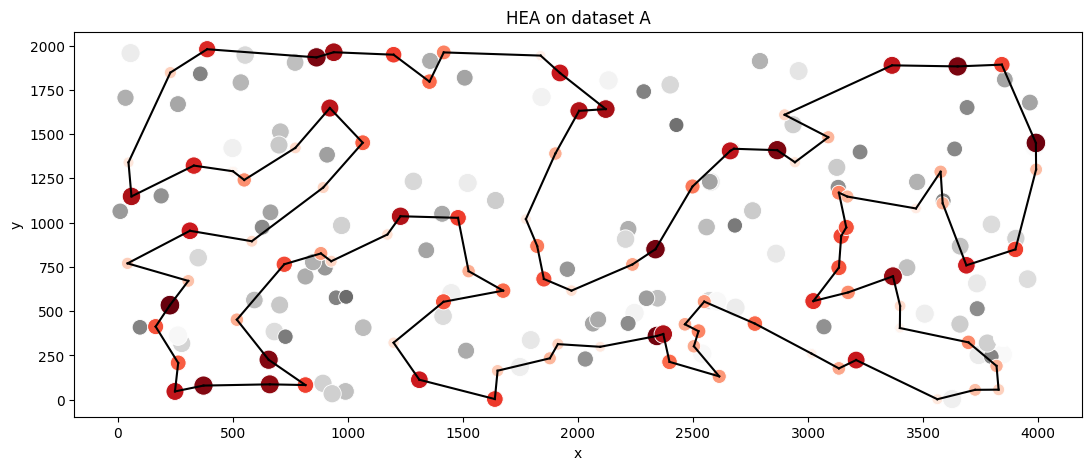

In [89]:
minimum_a = min(metrics_a, key=lambda x: x.cost)
mean_a = sum([metric.cost for metric in metrics_a]) / len(metrics_a)
maximum_a = max(metrics_a, key=lambda x: x.cost)
mean_n_iterations_a = sum([metric.num_iterations for metric in metrics_a]) / len(metrics_a)

print(f"Best solution: {minimum_a.solution}")
print("Objective function statistics:")
print(f"{minimum_a.cost = }\n{mean_a = }\n{maximum_a.cost= }")
print(f"Mean Number of iterations: {mean_n_iterations_a}")
plot_solution(ds_a, minimum_a.solution, title="HEA on dataset A")

## Results on DataSet B

In [5]:
metrics_b: list[HEAMetrics] = Parallel(n_jobs=-1)(
    delayed(run_hea_b)() for _ in range(HEA_RUNS)
)

Best solution: [95, 130, 99, 22, 179, 66, 94, 47, 148, 60, 20, 28, 149, 4, 140, 183, 152, 170, 34, 55, 18, 62, 124, 106, 143, 35, 109, 0, 29, 160, 33, 144, 111, 82, 21, 8, 104, 138, 11, 139, 168, 195, 13, 145, 15, 3, 70, 132, 169, 188, 6, 147, 90, 51, 121, 131, 135, 122, 133, 107, 40, 63, 38, 27, 1, 156, 198, 117, 193, 31, 54, 73, 136, 190, 80, 45, 175, 78, 5, 177, 36, 61, 91, 141, 77, 81, 153, 187, 163, 89, 127, 137, 114, 103, 113, 176, 194, 166, 86, 185]
Objective function statistics:
minimum_b.cost = 43518
mean_b = 43715.0
maximum_b.cost= 44233
Mean Number of iterations: 2332.8


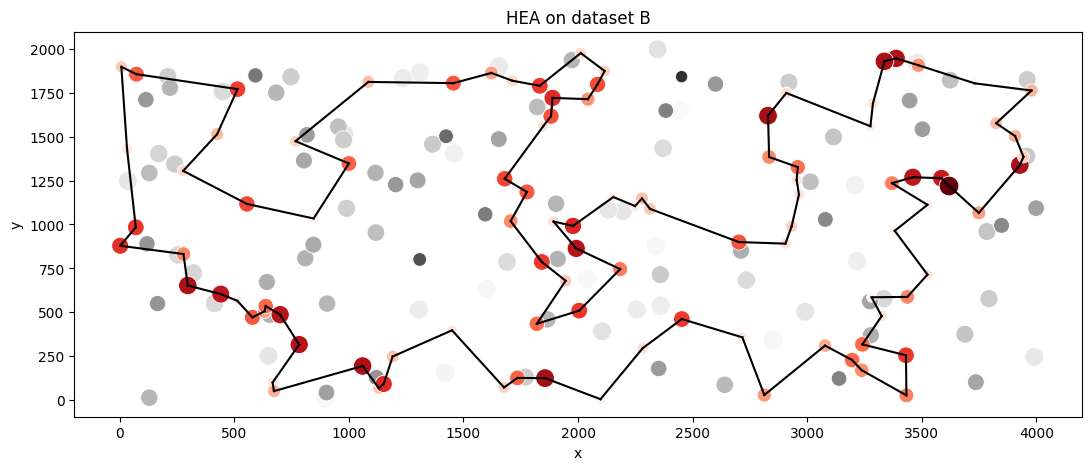

In [8]:
minimum_b = min(metrics_b, key=lambda x: x.cost)
mean_b = sum([metric.cost for metric in metrics_b]) / len(metrics_b)
maximum_b = max(metrics_b, key=lambda x: x.cost)
mean_n_iterations_b = sum([metric.num_iterations for metric in metrics_b]) / len(metrics_b)

print(f"Best solution: {minimum_b.solution}")
print("Objective function statistics:")
print(f"{minimum_b.cost = }\n{mean_b = }\n{maximum_b.cost= }")
print(f"Mean Number of iterations: {mean_n_iterations_b}")
plot_solution(ds_b, minimum_b.solution, title="HEA on dataset B")

# Summary

In [ ]:
a_res = pd.DataFrame(
    {
        "HEA": [69213, 69543.65, 69796, 2223, 2705.15],
        "Steepest edge LS": [72046, 74033.715, 78801, 9.54, 1],
        "MLSM": [70662, 71267.4, 71693, 2223, 200],
        "ILS": [69107, 69326.15, 69765, 2223, 1106.2],
        "LNS with LS": [69474, 70179.05, 71022, 2223, 3027.2],
        "LNS without LS": [69657, 70494.5, 71452, 2223, 6705.1],
        "Greedy weighted cycle": [71057.0, 72218.320, 73587.0, 0.4, 1],
    },
    index=pd.MultiIndex.from_tuples(
        [
            ("Dataset A", "min"),
            ("Dataset A", "mean"),
            ("Dataset A", "max"),
            ("Dataset A", "seconds/instance"),
            ("Dataset A", "iterations"),
        ]
    ),
).T

b_res = pd.DataFrame(
    {
        "HEA": [43518, 43715.0, 44233, 2218, 2332.8],
        "Steepest edge LS": [45393, 48264.78, 50697, 9.02, 1],
        "MLSM": [45321, 45751.25, 4613, 2218, 200],
        "ILS": [43493, 43783.05, 44312, 2218, 1114.8],
        "LNS with LS": [43568, 44290.55, 45011, 2218, 3058.25],
        "LNS without LS": [43595, 44507.05, 45558, 2218, 6717.85],
        "Greedy weighted cycle": [45453.0, 46252.105, 47884.0, 0.4, 1],
    },
    index=pd.MultiIndex.from_tuples(
        [
            ("Dataset B", "min"),
            ("Dataset B", "mean"),
            ("Dataset B", "max"),
            ("Dataset B", "seconds/instance"),
            ("Dataset B", "iterations"),
        ]
    ),
).T

a_res.join(b_res).sort_values(by=("Dataset A", "mean"))

Dataset A                                       \
                            min       mean      max seconds/instance   
ILS                     69107.0  69326.150  69765.0          2223.00   
HEA                     69213.0  69543.650  69796.0          2223.00   
LNS with LS             69474.0  70179.050  71022.0          2223.00   
LNS without LS          69657.0  70494.500  71452.0          2223.00   
MLSM                    70662.0  71267.400  71693.0          2223.00   
Greedy weighted cycle   71057.0  72218.320  73587.0             0.40   
Steepest edge LS        72046.0  74033.715  78801.0             9.54   

                                 Dataset B                      \
                      iterations       min       mean      max   
ILS                      1106.20   43493.0  43783.050  44312.0   
HEA                      2705.15   43518.0  43715.000  44233.0   
LNS with LS              3027.20   43568.0  44290.550  45011.0   
LNS without LS           6705.10   43595.0  44507.050  45558.0   
MLSM                      200.00   45321.0  45751.250   4613.0   
Greedy weighted cycle       1.00   45453.0  46252.105  47884.0   
Steepest edge LS            1.00   45393.0  48264.780  50697.0   

                                                   
                      seconds/instance iterations  
ILS                            2218.00    1114.80  
HEA                            2223.00    2332.80  
LNS with LS                    2218.00    3058.25  
LNS without LS                 2218.00    6717.85  
MLSM                           2218.00     200.00  
Greedy weighted cycle             0.40       1.00  
Steepest edge LS                  9.02       1.00

# Conclusion

Using the proposed Operators' configuration (with slight modifications), the HEA algorithm was tested under the same time budget as ILS and MSLS and run 20 times for each dataset. The results showed that HEA outperformed the other algorithms tested in this course, except for ILS. Incorporating ILS-style perturbations to escape unwanted convergence could be a potential improvement to further enhance HEA's performance.